# A Movie behind a Script


In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as psf
from pyspark.sql.utils import AnalysisException

from sacremoses import MosesDetokenizer

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim

#Gensim
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

C:\Users\Martin\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
spark = SparkSession.builder.getOrCreate()
#spark.conf.set('spark.sql.session.timeZone', 'UTC')
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# Overview of datasets

The OpenSubtitles dataset is a compressed cluster of folders containing XML files. Each XML file is split into a script portion with the subtitles of the movie and a metadata portion with additional information about the movie or show. The name of the second-parent folder of the XML file is the corresponding IMDb identifier of the movie or show, thus allowing us to extract additional information from the IMDb dataset.

## IMDb Dataset

We use the IMDb basics dataset, which provides us with a title's main information, and the ratings datasets, which provides us the IMDb rating and votes information for each title.

In [3]:
df_basics = spark.read.parquet("parquets/basics.parquet")
df_basics.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: double (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [4]:
df_ratings = spark.read.parquet("parquets/ratings.parquet")
df_ratings.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- averageRating: float (nullable = true)
 |-- numVotes: integer (nullable = true)



## OpenSubtitles dataset

The dataset consists of 31 GB of XML files distributed in the following file structure: 

```
├── opensubtitle
│   ├── OpenSubtitles2018
│   │   ├── Year
│   │   │   ├── Id
│   │   │   │   ├── #######.xml.gz
│   │   │   │   ├── #######.xml.gz
│   ├── en.tar.gz
│   ├── fr.tar.gz
│   ├── zh_cn.tar.gz
```
where
- `######` is a 6-digit unique identifier of the file on the OpenSubtitles dataset.
- `Year` is the year the movie or episode was made.
- `Id` is a 5 to 7 digit identifier (if it's 7-digit it's also an IMDb identifier).

The subtitles are provided in different languages. We only analyze the `OpenSubtitles2018` folder and it's the only folder we detail.

The decompressed XML files vary in size, ranging from 5KB to 9000KB sized files.

Each XML file is split into a `document` and `metadata` section.

### Document

The `document` section contains all the **subtitles** and its general structure is the following:

```
├── s
│   ├── time: Integer
│   ├── w: String
```

An example snippet of an XML file:

```xml
  <s id="1">
    <time id="T1S" value="00:00:51,819" />
    <w id="1.1">Travis</w>
    <w id="1.2">.</w>
    <time id="T1E" value="00:00:53,352" />
  </s>
```

The subtitles in each XML file are stored by **blocks** denoted by `s` with a unique `id` attribute (integers in increasing order starting at 1).  

Each block (`<s id="1">` for instance) has a:  

1. Set of timestamps (denoted by `time`) with
 - A timestamp `id` attribute that can take two different formats: `T#S` or `T#E`, where _S_ indicates _start_, _E_ indicates _end_ and _#_ is an increasing integer. 
 - A `value` attribute which has the format `HH:mm:ss,fff`.

2. Set of words (denoted by `w`) with
 - an `id` attribute that is simply an increasing number of decimal numbers of the format `X.Y` where X is the string id and Y is the word id within the corresponding string
 - a non-empty `value` attribute that contains a token: a word or a punctuation character. 

It sometimes also has an `alternative`, `initial` and `emphasis` attribute.  

 - The `initial` attribute generally corresponds to slang words or mispronounced words because of an accent such as _lyin'_ instead of _lying_.  
 - The `alternative` attribute is another way of displaying the subtitle for example _HOW_ instead of _how_.
 - The `emphasis` attribute is a boolean.

### Metadata

The `metadata` section has the following structure:

```
├── Conversion
│   ├── corrected_words: Integer
│   ├── sentences: Integer
│   ├── tokens: Integer
│   ├── encoding: String (always utf-8)
│   ├── unknown_words: Integer
│   ├── ignored_blocks: Integer
│   ├── truecased_words: Integer
├── Subtitle
│   ├── language: String
│   ├── date: String
│   ├── duration: String
│   ├── cds: String (presented as #/# where # is an int)
│   ├── blocks: Integer
│   ├── confidence: Double
├── Source
│   ├── genre: String[] (up to 3 genres)
│   ├── year: Integer
│   ├── duration: Integer (in minutes)
│   ├── original: String
│   ├── country: String
```

We note that some XML files may not have all the entries. 
We can use the metadata to obtain additional information about the movie or show's subtitles and compute certain statistics. 

## Exploration of our data sets

Going through the dataset we notice a few things:

1. The dataset has meaningless folders. For example, the folder 1858/ is empty.
2. Dataset contains XML files that are not related to movies or TV shows. For example, the folder 666/ contains Justin Bieber song subtitles.  
3. Trailer of films can be present in the dataset. For example, the folder 2018/ we found for example Black Panther teaser trailer subtitles.
4. Each movie might have more than 1 subtitle file.
5. Some subtitle files contain text that is not related to the movie, like credits to the person who made the subtitles.
7. Each block may have an arbitrary number (including 0) of timestamps associated to it.

To solve points 1, 2 and 3 we decide to take only files associated with valid IMDb id's of movies with more than 5000 reviews.

To solve point 4, we simply take the first one.

To solve point 6, we keep movies that have a correct IMDb identifier. Hence, all the files in folders that don't have a 7-digit folder name are dropped.

To solve point 7, we decide not to associate a timestamp to each word.
 
We extract the desired dataset information into a parquet file using the script `parquet2.py` (TODO rename). From this parquet we extract all the information for the data analysis.

Moreover, to avoid confusion, we set some naming conventions. We refer to certain attributes as follows:

- The `s` array as **blocks**
- An element of blocks, as a **block**.
- The `w` array as **elements**
- An element of elements, as **element**.
- `_VALUE` as a **token**
- A **subtitle** is a list of tokens

# Data analysis

## Objective and structure

As stated in our abstract, our main goal is to try to find a relation between a film subtitles and the average rating: __What makes a movie good or bad?__  

To answer the question we follow this structured plan:
1. **Selection of data**: Select and clean data relevant to our problem.
2. **Exploration of data**: Analyze the distribution of different features of our data, such as most represented genres, years, etc.
3. **Extract features** from the subtitles. Try to find correlations between such features and movies average ratings.
4. Implement a **linear regression** using such statistics.
5. **Analysis**: Comment results.
6. **Natural Language Processing (NLP)**: Use NLP tools such as sentiment analysis and topic detection to extract additional features. TODO
7. Test a **regression** using the new features
8. **Conclusion**

## Data selection

To see if one can predict the average IMDb rating using the subtitles of a movie, the data is restricted according to the following criteria:
1. __the movie must have been rated at least 5000 times__: indeed we consider this a good minimum threshold to estimate the public approval of a film. In comparison, for a movie to be included in the IMDb top 250 movies, a movie must receive at least 25,000 user ratings.
2. __the file identifier must be a valid IMDb identifier__: this ensures that the corresponding IMDb data is present in the `basics` and `rating`. 
3. __the title type must be of a movie__.

We also define helper functions :

- a function that retrieves the tokens from the elements (`w` array) and returns an array of subtitles, where each subtitle is a list of tokens.
- a function to split the genres. Multiple genres are provided as a single string, so we must define a function to split the string and return an array of genres.
- a function that joins all the words of a movie
- a function that determines whether an XML document has the correct schema and can thus be processed for our analysis.

The helper functions help us fulfill certain criteria laid out above. The script `parquet2.py` is ran on the cluster to load the `.xml` files into a spark dataframe containing the movie information required for our analysis, which is then stored in a parquet file for convenience.

In [5]:
def to_subtitles_array(sentences):
    """Function to map the elements (a struct containing tokens)
    to a list of list of tokens """
    s_list = []
    if sentences is None:
        return s_list
    for words in sentences:
        w_list = []
        if words and "w" in words and words["w"]:
            for w in words["w"]:
                if '_VALUE' in w and w['_VALUE']:
                    w_list.append(w['_VALUE'])
                
            s_list.append(w_list)

    return s_list

In [6]:
# Function to split genres
udf_split = psf.udf(lambda s: s.split(',') if s is not None else "", ArrayType(StringType()))

In [7]:
# Transform to spark function
udf_subtitles_array = psf.udf(to_subtitles_array, ArrayType(ArrayType(StringType())))
# Convert array of words into a single string
udf_sentence = psf.udf(lambda x: ' '.join(x), StringType())

In [8]:
# Check correct schema
def has_correct_schema(df):
    arguments = ["meta.conversion.sentences",
                 "meta.source.year", 
                 "meta.subtitle.blocks",
                 "meta.subtitle.duration",
                 "meta.subtitle.language",
                 "s"]
    for col in arguments:
        try:
            df[col]
        except AnalysisException:
            return False
    return True

schema_films = StructType([StructField('tconst', StringType(), False),
                           StructField('num_sentences', LongType(), True),
                           StructField('year', LongType(), True),
                           StructField('blocks', LongType(), True),
                           StructField('subtitle_mins', DoubleType(), True),
                           StructField('subtitles', ArrayType(ArrayType(StringType())), True)])

The function below structures our data to the format we want to then process all the queries we need. 
We link the movie with the proper IMDb id, we get all the subtitles and convert the subtitle duration to seconds.

In [9]:
def clean_df(df_document, imdb_id):
    """Restructures and selects the columns of a dataframe of an XML
    file with its corresponding IMDB Id"""
    # Create IMDb ID and subtitles column
    df_film_sentences = df_document.withColumn("tconst", psf.lit("tt" + imdb_id))\
                                   .withColumn("subtitles", udf_subtitles_array("s"))
    
    # Select metadata and previously created columns
    df_result = df_film_sentences.selectExpr("tconst",
                                             "meta.conversion.sentences as num_sentences",
                                             "meta.source.year", 
                                             "meta.subtitle.blocks",
                                             "meta.subtitle.duration as subtitle_duration",
                                             "meta.subtitle.language",
                                             "subtitles")
    # Split genre column and convert subtitle duration to seconds
    df_result = df_result.withColumn("subtitle_mins", 
                                     psf.unix_timestamp(df_result.subtitle_duration, "HH:mm:ss,SSS") / 60)
    # Discard redundant columns
    df_result =  df_result.select("tconst", 
                                  "num_sentences", 
                                  "year", 
                                  "blocks", 
                                  psf.when(psf.col("subtitle_mins") > 0, psf.col("subtitle_mins"))\
                                     .otherwise(None)\
                                     .alias("subtitle_mins"), 
                                  "subtitles")
    return df_result

As we must process several XML files into dataframe, we define a function that does this.

In [10]:
def load_df(path):
    """Load an XML subtitles file into a dataframe"""
    df_film = sqlContext.read.format('com.databricks.spark.xml')\
                             .options(rowTag='document')\
                             .load(path)
    return df_film

We can't generate a single parquet file for all of our movies in one process, so we use the following function to merge several parquet files onto 1.

In [11]:
def unionAll(*dfs):
    first, rest = dfs[0], dfs[1:]  # Python 3.x, for 2.x you'll have to unpack manually
    return first.sql_ctx.createDataFrame(
        first.sql_ctx._sc.union([df.rdd for df in dfs]),
        first.schema
    )
#df_films = unionAll(*film_list)

The data can be accessed by loading `films.parquet` and `films2.parquet` into a spark dataframe. The first one contains in the subtitle column only the words present in the film and the second one also includes the punctuation marks.

## Droping NaNs : 

In [12]:
# Load data 
df_films = spark.read.parquet('parquets/films.parquet')
df_films.count()

4286

We check if we have any null values that might affect our statistics.

In [13]:
df_films.dropna().count()

4224

The number is fairly small and is due to the conversion of subtitle minutes of some XML files that had a slightly different datetime format. We drop films with null values to avoid incorrect data.

In [14]:
df_films_clean = df_films.dropna()

We also noticed that some movies have the feature `subtitle_mins` with a negative value wich is a non-sense as it represents the time during which subtitles are displayed on the screen. We decided to drop this rows as well. 

In [15]:
df_films = df_films.filter(df_films['subtitle_mins'] > 0)                

In [16]:
# Save the dataframe 
df_films_clean.write.mode("overwrite").parquet("parquets/filmsclean.parquet")

In [17]:
# Same for films2.parquet
df_films2 = spark.read.parquet('parquets/films2.parquet')
df_films2_clean = df_films2.dropna()
df_films2_clean = df_films2.filter(df_films2['subtitle_mins'] > 0)        
df_films_clean.write.mode("overwrite").parquet("parquets/filmsclean2.parquet")

## Exploration of the data 

In [18]:
df_films = spark.read.parquet("parquets/filmsclean.parquet")

The total films we will be focusing on then is:

In [19]:
df_films.count()

4224

The dataframe we work with has the following form:

In [20]:
df_films.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- num_sentences: long (nullable = true)
 |-- year: long (nullable = true)
 |-- blocks: long (nullable = true)
 |-- subtitle_mins: double (nullable = true)
 |-- subtitles: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)



In [21]:
df_basics

DataFrame[tconst: string, titleType: string, primaryTitle: string, originalTitle: string, isAdult: string, startYear: string, endYear: string, runtimeMinutes: double, genres: array<string>]

We first make a simple exploration of our dataset, joining it with the IMDb ratings dataframe.

In [22]:
df_ratings

DataFrame[tconst: string, averageRating: float, numVotes: int]

In [23]:
df_movies = df_basics.filter(df_basics['titleType'] == 'movie')\
                     .select('tconst','originalTitle','runtimeMinutes','genres',)\
                     .join(df_ratings.filter(df_ratings.numVotes >= 5000)\
                                     .select('tconst','averageRating'),
                           on="tconst")

df_films_stats = df_films.join(df_movies,["tconst"])\
                         .drop("subtitles")\
                         .toPandas()

In [24]:
df_movies.show()

+---------+--------------------+--------------+--------------------+-------------+
|   tconst|       originalTitle|runtimeMinutes|              genres|averageRating|
+---------+--------------------+--------------+--------------------+-------------+
|tt0004972|The Birth of a Na...|         195.0|[Drama, History, ...|          6.7|
|tt0006864|Intolerance: Love...|         163.0|    [Drama, History]|          8.0|
|tt0009968|Broken Blossoms o...|          90.0|    [Drama, Romance]|          7.6|
|tt0010323|Das Cabinet des D...|          76.0|[Fantasy, Horror,...|          8.1|
|tt0011237|Der Golem, wie er...|          91.0|   [Fantasy, Horror]|          7.2|
|tt0012349|             The Kid|          68.0|[Comedy, Drama, F...|          8.3|
|tt0012364|           Körkarlen|         100.0|[Drama, Fantasy, ...|          8.1|
|tt0013086|Dr. Mabuse, der S...|         242.0|[Crime, Mystery, ...|          7.9|
|tt0013257|               Häxan|          91.0|[Documentary, Fan...|          7.7|
|tt0

### What genres are present in our dataset ? 

Here is the distribution of the different appearing genres of our dataset, we need to consider aswell that a movie might can have multiple genres : __comedy__ and __drama__, for instance.

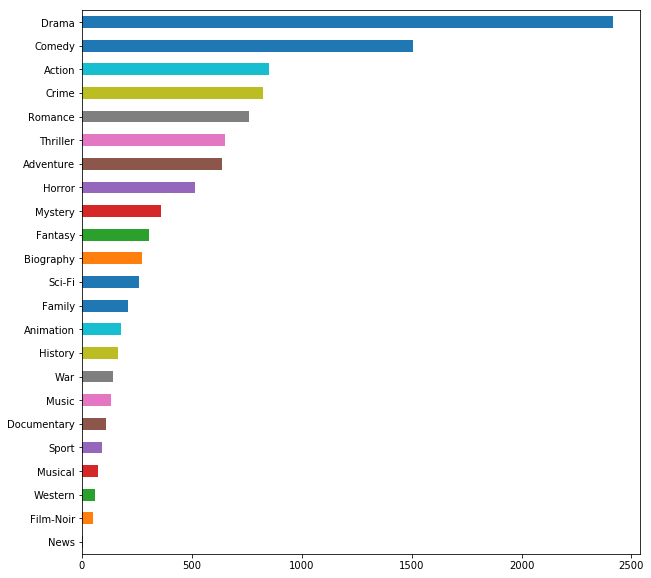

In [25]:
# TODO Change style of graphe 
# TODO add x-axis label
# Plotting genre distribution 
genres = [item for sublist in df_films_stats["genres"] for item in sublist]
ax = pd.Series(genres).groupby(genres).count().sort_values().plot.barh(figsize=(10,10))

### How is our dataset distributed through time?

Oldest movie in our dataset was released on: 1922
Newest movie in our dataset was released on: 2017


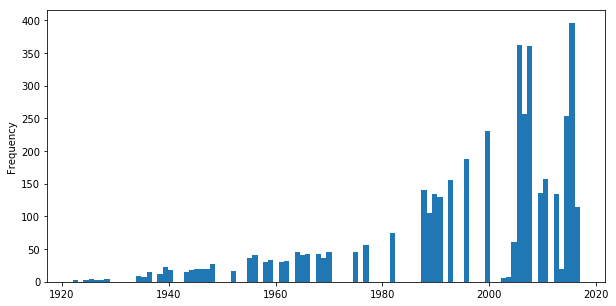

In [26]:
# TODO Change style of graphe 
print("Oldest movie in our dataset was released on: {:}".format(df_films_stats["year"].min()))
print("Newest movie in our dataset was released on: {:}".format(df_films_stats["year"].max()))
ax = df_films_stats["year"].plot.hist(bins=96, figsize=(10,5))

As we can see the data is not distributed evenly through time, a lot of years are missing and more recent films appear more. It will be then difficult to take time into account as a good metric to predict the rating given the uneven distribution

### How is the total film runtime distributed?

Shortest movie in our dataset is: 60.0 minutes long
Longest movie in our dataset is: 467.0 minutes long


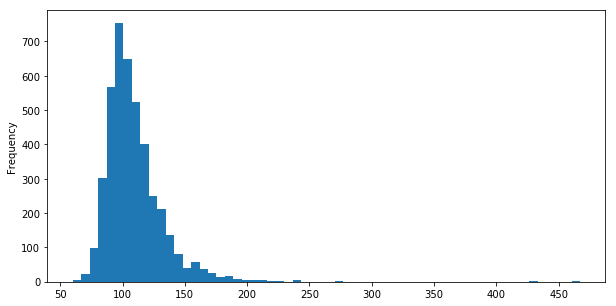

In [27]:
# TODO Change style of graphe 
print("Shortest movie in our dataset is: {:} minutes long".format(df_films_stats["runtimeMinutes"].min()))
print("Longest movie in our dataset is: {:} minutes long".format(df_films_stats["runtimeMinutes"].max()))

# TODO add x-axis label!
ax = df_films_stats["runtimeMinutes"].plot.hist(bins=60, figsize=(10,5))

Apart from some outliers, our data is well centered to the runtime value of 100 minutes.

### What about the ratings?

Worst rated movie in our dataset has: 1.7 rating
Best rated movie in our dataset has: 9.4 rating
Average rating in our dataset is 6.7


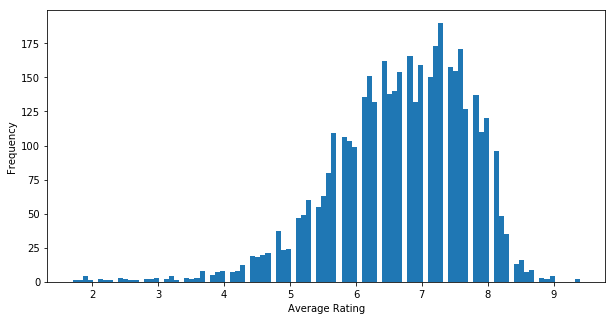

In [28]:
# TODO Change style of graphe 
print("Worst rated movie in our dataset has: {:.1f} rating".format(df_films_stats["averageRating"].min()))
print("Best rated movie in our dataset has: {:.1f} rating".format(df_films_stats["averageRating"].max()))
print("Average rating in our dataset is {:.1f}".format(df_films_stats["averageRating"].mean()))
ax = df_films_stats["averageRating"].plot.hist(bins=100, figsize=(10,5))
ax.set_xlabel("Average Rating")
# ax.savefig

In [29]:
df_films_stats.sort_values("averageRating", ascending=False).head(10)

,tconst,num_sentences,year,blocks,subtitle_mins,originalTitle,runtimeMinutes,genres,averageRating
2936,tt0252487,1617,1975,675,24.450000,Hababam Sinifi,87.0,"[Comedy, Drama]",9.4
3724,tt5813916,1570,2016,1440,71.366667,Dag II,135.0,"[Drama, War]",9.4
3105,tt0252488,1689,1975,1113,23.283333,Hababam Sinifi Sinifta Kaldi,91.0,[Comedy],9.0
3880,tt5275892,6236,2016,1829,406.050000,O.J.: Made in America,467.0,"[Biography, Crime, Documentary]",9.0
1648,tt0468569,2050,2008,694,86.433333,The Dark Knight,152.0,"[Action, Crime, Drama]",9.0
1193,tt0084302,1045,1982,462,29.433333,Maratonci trce pocasni krug,92.0,"[Comedy, Drama]",9.0
430,tt0108052,2917,1993,1133,126.366667,Schindler's List,195.0,"[Biography, Drama, History]",8.9
1006,tt0060196,2071,1966,1434,282.416667,"Il buono, il brutto, il cattivo",161.0,[Western],8.9
1147,tt1375666,1570,2010,1190,79.416667,Inception,148.0,"[Action, Adventure, Sci-Fi]",8.8
3797,tt3417422,2603,2013,2423,102.816667,Drishyam,160.0,"[Crime, Drama, Thriller]",8.8


## Genre Exploration

We want also to look at the average rating for the different genres. We first look at distribution the average genre ratings of our dataset compared to the whole IMDb data set, to see if the distribution is similar as we are dealing with a much smaller amount of films.

In [30]:
df_genres = df_films.drop("subtitles").join(df_movies, ["tconst"])

In [35]:
df_genres_avRating = df_genres.select('*', 
                                      psf.explode('genres').alias('genre'))\
                              .groupBy("genre").agg({"averageRating": "mean", 
                                                     "*": "count"})
df_genres_rating = df_genres_avRating.sort("count(1)", ascending=False).limit(10)\
                                        .withColumnRenamed("avg(averageRating)", "Subtitle dataset rating").drop("count(1)")
                

In [37]:
df_imdb_avRating = df_movies.select('*', psf.explode('genres').alias('genre'))\
                            .groupBy("genre").agg({"averageRating": "mean", 
                                                     "*": "count"})
df_imdb_avRating = df_imdb_avRating.sort("count(1)", ascending=False)\
                                      .limit(10).withColumnRenamed("avg(averageRating)", "IMDb dataset rating").drop("count(1)")
df_all_ratings = df_imdb_avRating.join(df_genres_rating, ["genre"]).toPandas()

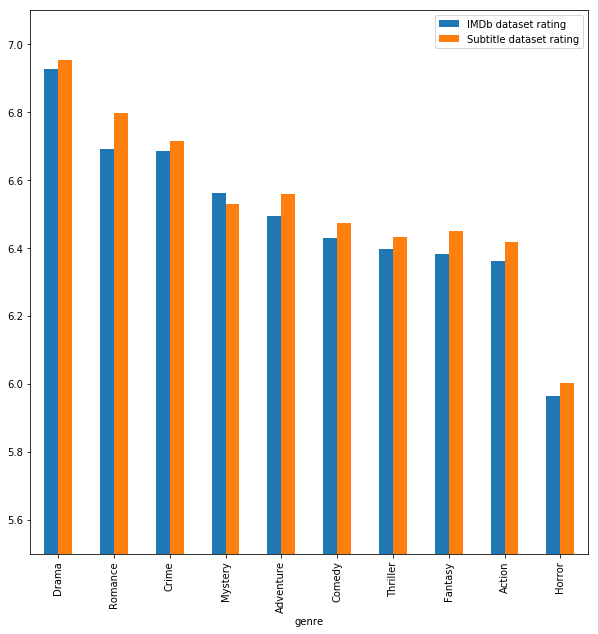

In [41]:
yvar = ["IMDb dataset rating", "Subtitle dataset rating"]
df_all_ratings.sort_values("IMDb dataset rating", ascending=False).plot.bar(y=yvar, x="genre", figsize=(10,10))
plt.ylim(5.5, 7.1)
plt.show()

We can see that there are no very big differences between genres ratings apparently, though we can see that a Drama movie is more likely to have a good rating than a horror movie. From these statistics we could assume that the genre has somehow an influence in the film's average rating. The comparaison with the IMDB dataset shows that our data follows a very similar pattern with the genre ratings but generally having an better average rating than the IMDB data set, this can be explained as our dataset is smaller, the average values are impacted more by outliers

## Time Exploration

We categorize our subtitles distribution into 3 time periods as we have seen that our dataset is not balanced in terms of distribution through time. We extract the average rating of each period, aswell as the rating by genre.

In [42]:
def add_time_period(year):
    if year < 1910 or year > 2018:
        return "NaN"
    elif year < 1960:
        return "1910-1959"
    elif year < 2000:
        return "1960-1999"
    else:
        return "2000s"
udf_period = psf.udf(add_time_period, StringType())

In [43]:
df_ratings_periods = df_movies.join(df_films.select("year", "tconst"), ["tconst"])\
                                            .withColumn("period", udf_period("year"))

In [44]:
df_ratings_periods.groupBy("period")\
                  .agg({"averageRating": "mean", "*": "count"})\
                  .show()

+---------+------------------+--------+
|   period|avg(averageRating)|count(1)|
+---------+------------------+--------+
|    2000s| 6.465611225999668|    2495|
|1910-1959| 7.583113493579673|     379|
|1960-1999| 6.831037049823337|    1350|
+---------+------------------+--------+



__Are films getting worse?__  
We cannot be sure as the amount of films is not big enough but from our data. 
Indeed we have much more data for the time period 1960-1999 than 1910-1959 as we have seen shown in the table above, and even more data for from 2000 up to now.
This descrepency is easily understantable as the techniques of cinema progressed with science and it is easier and cheaper to make a movie today than it used to be.
Another potential source of bias is the fact that the movies that sruvived through time are usually good movies. 
Thus, this movies have better IMDb avrage ratings and pull up the average rating for the given time period. 
On the contrary, most of the films that were produced more recently are present in IMDb and in the OpenSubtitles data set, but this movies do not necessarly have good ratings, and actually lower the average. 

With this ideas in mind, we check the distribution of average rating for the different genres present in our dataset for the different time periods. 

In [45]:
df_periods_stats = df_ratings_periods.join(df_genres.select("tconst", 
                                                                  psf.explode('genres').alias('genre')), 
                                                 ["tconst"])\
                                           .groupBy("period", "genre").agg({"averageRating": "mean", 
                                                                            "*": "count"})
df_periods_stats_pd = df_periods_stats.toPandas()

In [46]:
df_genres = df_films.drop("subtitles").join(df_basics.select("tconst", 
                                                             "genres", 
                                                             "primaryTitle", 
                                                             "runtimeMinutes"), 
                                            ["tconst"])
df_genres= df_genres.join(df_ratings, ["tconst"])

We decide to take film genres only with more than 100 appereances, to have better confidence in our results and we plot by time period again the average rating of each genre. We first look at the whole dataframe to see the "best type of movie" taking into account the period and the genre.

In [47]:
df_genre_period = df_periods_stats_pd[df_periods_stats_pd["count(1)"] > 100].sort_values("count(1)", ascending=False)

In [48]:
df_genre_period.sort_values("avg(averageRating)", ascending=False)

,period,genre,avg(averageRating),count(1)
61,1910-1959,Drama,7.634457,267
52,1910-1959,Romance,7.581897,116
53,2000s,Biography,7.152717,184
47,1960-1999,Drama,7.139305,748
37,1960-1999,Romance,6.943056,216
64,1960-1999,Crime,6.737943,282
11,1960-1999,Thriller,6.734973,183
9,2000s,Drama,6.731527,1421
32,1960-1999,Adventure,6.689202,213
17,2000s,Animation,6.615267,131


We now plot the average rating for the different genres given a time period

C:\Users\Martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


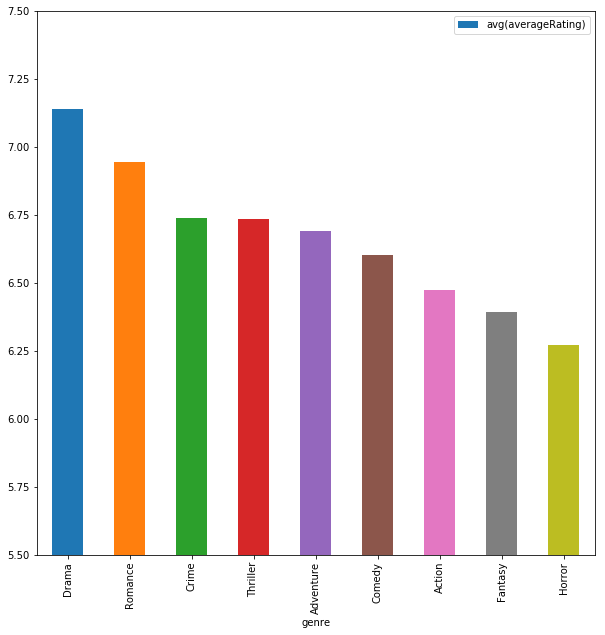

In [50]:
df_genre_period[df_periods_stats_pd.period == "1960-1999"].head(15)\
                    .sort_values("avg(averageRating)", 
                                 ascending=False).plot.bar(x="genre", y ="avg(averageRating)", figsize=(10,10))
plt.ylim(5.5, 7.5)
plt.show()

C:\Users\Martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


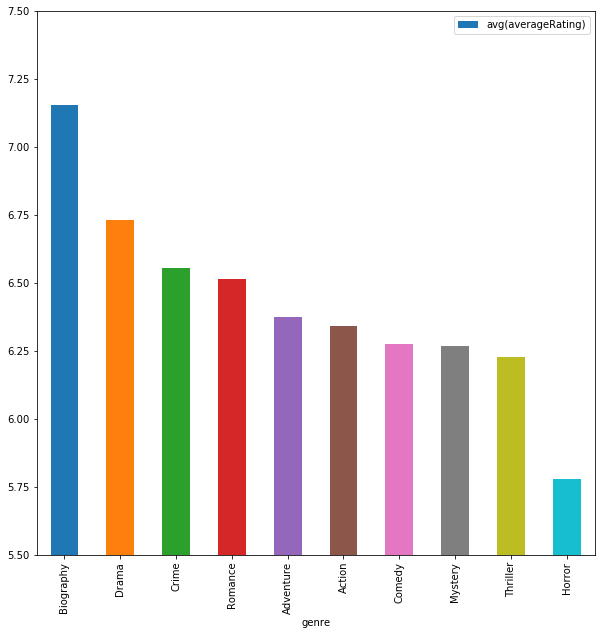

In [51]:
df_genre_period[df_periods_stats_pd.period == "2000s"].head(10)\
                    .sort_values("avg(averageRating)", 
                                 ascending=False).plot.bar(x="genre", y ="avg(averageRating)", figsize=(10,10))
plt.ylim(5.5, 7.5)
plt.show()

In [ ]:
#TODO: on peut devrait en faire un tableau plutot que 2 plots pour tout résumé. 

As we can see, there is no major difference between both graphs. 

## Simple statistics: searching for a correlation between average IMDb rating and text features. 

"Raw" features are extracted from the subtitles and the metadata : 
* the total number of words relative to the movie duration. 
* the total number of distinct words relative to the movie duration.
* the total number of sentences relative to the movie duration.
* the mean average length of the subtitles.
* the subtitles to movie duration ratio.
* the number of distinct words divided by the length of the movie, the total number of words and the mean average length of the sentences.

We define the following method to extract these features from our dataframe.

In [52]:
def word_statistics(df_films):
    # Explode the sentences t
    df_words = df_films.select('*', psf.explode('subtitles').alias('words'))
    df_words = df_words.select('*', psf.explode('words').alias('word'))

    df_word_counts = df_words.groupby("tconst", "num_sentences", "subtitle_mins")\
                             .agg(psf.count("word").alias("num_words"), 
                                  psf.countDistinct("word").alias("num_distinct_words"))\
                             .join(df_basics, ['tconst'], 'inner')\
                             .withColumn("words_per_min",
                                         psf.col("num_words") / psf.col("runtimeMinutes"))\
                             .withColumn("distinct_words_per_min",
                                         psf.col("num_distinct_words") / psf.col("runtimeMinutes"))\
                             .withColumn("sentences_per_min",
                                         psf.col("num_sentences") / psf.col("runtimeMinutes"))\
                             .withColumn("mean_length_sentences",
                                         psf.col("num_words") / psf.col("num_sentences"))\
                             .withColumn("distinct_index", 
                                         1000 * psf.col("num_distinct_words") /(psf.col("num_sentences")*
                                                                                psf.col("runtimeMinutes")*
                                                                                psf.col("num_words")))\
                             .withColumn("times_ratio",
                                         psf.when(psf.col("subtitle_mins").isNotNull(), 
                                                  psf.col("subtitle_mins") / psf.col("runtimeMinutes") * 100))
    
    df_word_counts = df_word_counts.select("tconst",
                                           "num_words",
                                           "num_distinct_words",
                                           "num_sentences",
                                           "subtitle_mins",
                                           "runtimeMinutes",
                                           "mean_length_sentences",
                                           "words_per_min",
                                           "distinct_words_per_min",
                                           "sentences_per_min",
                                           "distinct_index",
                                           "times_ratio")
    return df_word_counts

In [62]:
# Load data  
df_films = spark.read.parquet("parquets/filmsclean.parquet")

AnalysisException: 'Unable to infer schema for Parquet. It must be specified manually.;'

In [54]:
# Generating the df of statistics 
df_stats = word_statistics(df_films)

### Trailers in the dataset

With this new statisitics computed, we noticed that some subtitles managed to passe through our filters.
To discard those subtitles we look at how many words are used.
We choose to discard words that used less than 600 words.  
The idea is : Eminem in his song "Rap God" has the world record of words pronounced in a given time. 
On averaged he pronounced 4,28 words per sec.
Thus, we expect people to speak at most at 2 words per sec. 
If a trailer lasts at maximum 300 seconds, that leads us to 600 words. 
Hence we discard the subtitles that have less 600 words.

To add, nobody speaks faster than that so we remove movies that lead to a higher word per sec value.

In [55]:
df_stats = df_stats.filter(df_stats['num_words'] > 600)
df_stats = df_stats.filter(~(df_stats['words_per_min']/60 > 4.28 ))

In [56]:
df_stats.write.mode("overwrite").parquet("parquets/statsclean.parquet")

In [57]:
df_films = df_films.join(other=df_stats.select('tconst'), 
                         on='tconst',
                         how='inner')

In [58]:
df_films = df_films.drop_duplicates()

In [59]:
df_films.show()

+---------+-------------+----+------+------------------+--------------------+
|   tconst|num_sentences|year|blocks|     subtitle_mins|           subtitles|
+---------+-------------+----+------+------------------+--------------------+
|tt0032553|         1482|1940|  1268| 59.71666666666667|[[At, the, end, o...|
|tt0032599|         2883|1940|  1973|             31.35|[[Copy, boy], [Ma...|
|tt0036323|         1272|1943|   499|             33.85|[[US, Tank, Detac...|
|tt0039305|         1597|1947|  1148|              36.1|[[Get, your, Sund...|
|tt0063688|         1033|1968|   768| 40.68333333333333|[[What, goin, on,...|
|tt0066193|         1729|1970|  1023| 32.93333333333333|[[Gwen, come, on]...|
|tt0100142|         1940|1990|  1517| 36.21666666666667|[[You, mustn, lis...|
|tt0102216|         1561|1991|  1446| 33.38333333333333|[[The, rain, appe...|
|tt0107840|         1737|1993|  1085| 43.88333333333333|[[You, like, the,...|
|tt0117718|         1114|1996|  1183|52.333333333333336|[[Maine,

In [63]:
#df_films.write.mode("overwrite").parquet("parquets/filmsclean.parquet") #TODO Virer cette ligne ou la faire 

### Plots 

We provide a descriptive analysis of our features by producing scatter plots and histograms. We convert our Spark dataframe to a Pandas dataframe in order to produce plots.

#### Conversion to pandas dataframe 

In [ ]:
# Load from parquet 
df_words_stats = spark.read.parquet("parquets/statsclean.parquet")

In [ ]:
# join with ratings to get average rating: 
df_words_ratings = df_words_stats.join(other=df_ratings, 
                                       on='tconst', 
                                       how='inner')
# join with basics to get title:
df_words_ratings = df_words_ratings.join(other=df_basics.select('tconst',
                                                                'originalTitle', 
                                                                'titleType'), 
                                         on='tconst', 
                                         how='inner')

In [ ]:
df_words_ratings_pd = df_words_ratings.toPandas()

In [ ]:
df_words_ratings_pd.head()

In [ ]:
features = ["words_per_min", "distinct_words_per_min","sentences_per_min","mean_length_sentences",  "distinct_index","times_ratio"]
df_words_ratings_pd.describe()[features]

### Scatter plots

We compute the correlation between our statistics and the average rating of a film and we look at different scatter plots. On the X-axis we put our statistics and on the Y-axis the average rating. We want to use the features that reveal the most information about the rating of a movie for a regression.

In [ ]:
df_words_ratings_pd["averageRating"].corr()["features"]

In [ ]:
fig, axes = plt.subplots(nrows=3, 
                         ncols=2, 
                         figsize=(30,30))

df_words_ratings_pd.plot(kind="scatter",
                         ax=axes[0,0],
                         x="words_per_min",
                         y="averageRating",
                         fontsize=20)
df_words_ratings_pd.plot(kind="scatter",
                         ax=axes[0,1],
                         sharey=True,
                         x="distinct_words_per_min", 
                         y="averageRating",
                         fontsize=20)
df_words_ratings_pd.plot(kind="scatter",
                         ax=axes[1,0],
                         x="sentences_per_min", 
                         y="averageRating",
                         fontsize=20)
df_words_ratings_pd.plot(kind="scatter",
                         ax=axes[1,1],
                         x="mean_length_sentences", 
                         y="averageRating",
                         fontsize=20)
df_words_ratings_pd.plot(kind="scatter",
                         ax=axes[2,0],
                         x="distinct_index", 
                         y="averageRating",
                         fontsize=20)
df_words_ratings_pd.plot(kind="scatter",
                         ax=axes[2,1],
                         x="times_ratio", 
                         y="averageRating",
                         fontsize=20)

axes[0,0].set_xlabel("Words per minute", 
                     fontsize=24)
axes[0,1].set_xlabel("Distinct words per minute", 
                     fontsize=24)
axes[1,0].set_xlabel("Sentences per minute", 
                     fontsize=24)
axes[1,1].set_xlabel("Mean length sentences", 
                     fontsize=24)
axes[2,0].set_xlabel("Distinct index", 
                     fontsize=24)
axes[2,1].set_xlabel("$\\tau_{subs}/ \\tau_{movies} [\\%]$", 
                     fontsize=24)

axes[0,0].set_ylabel("Average IMDb rating", 
                     fontsize=24)
axes[1,0].set_ylabel("Average IMDb rating", 
                     fontsize=24)
axes[2,0].set_ylabel("Average IMDb rating", 
                     fontsize=24)
axes[2,1].set_xlim(0,100);


#### Analysis


The plots of word features, ``words per minute`` and ``distinct words per minute``  reveal that there is no clear distinction in the average IMDb rating based on the number of words employed in a movie.

* The idea behind the ratio $\frac{Number\;of\;Words}{\text{Length of Movie}}$ is simply to take into account that a movie that is longer could have in proportion the same amount of words employed. Indeed, a longer movie is not necessarly more verbose, it could only have more words used in it because it is longer. 
* The second plot where we take into account also distinct words per minute does not provide much more information than the first and actually shows data more evenly distributed. 

From the ``mean sentence length`` plot, it appears that again no clear trend can be established based on this statistics. 
Nevertherless, it seems that a larger number of sentences for the raw number of sentences and normalized with respect to movie length, correlates positevely with a higher IMDb rating. 
To have a higher IMDb rating it is not necessary to have longer sentences, as most of data is packed between a 1'000 and 3'000 sentences in the subtitles.  
But, it can be observed that a positive correlation appears for the movies with the longest sentences: looking at the data on the right edge of the blobe shows that as the number of sentences increase, the average IMDb rating increases, as if passed a certain number of sentences guarantees a certain IMDb average rating. 
Without doubt, it is not the effect of longer sentences that is observed here, but longer sentences are more complicated to be written. Thus it can give an idea on how well the scripts of this movies where written and that could correlate positively with higher IMDb.


#### Outliers

It is also interesting to see what is up with the outliers in our plots, we can see some values in extremely isolated places and we want to explain why they have such values

### Histograms
We also plot histograms of each feature for films considered "good" and "bad". We take a balanced set of good and bad films by considering good films as the ones that have more than 8 as IMDb rating and bad those who have less than 5.2.

In [ ]:
bad_movies = df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5.2]
good_movies = df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]

In [ ]:
print("Number of bad movies: {}".format(bad_movies["tconst"].count())) 
print("Number of good movies: {}".format(good_movies["tconst"].count()))

In [ ]:
fig, axes = plt.subplots(nrows=3, 
                         ncols=2, 
                         figsize=(30,30))

bad_movies["words_per_min"].plot(kind="hist",
                                 ax=axes[0,0],
                                 fontsize=20, 
                                 alpha=0.8, 
                                 label="bad films", 
                                 bins=20)
good_movies["words_per_min"].plot(kind="hist",
                                  ax=axes[0,0],
                                  fontsize=20,
                                  alpha=0.6, 
                                  label="good films",
                                  bins=20)

bad_movies["distinct_words_per_min"].plot(kind="hist",
                                          ax=axes[0,1],
                                          fontsize=20, 
                                          alpha=0.8,  
                                          label="bad films", 
                                          bins=20)
good_movies["distinct_words_per_min"].plot(kind="hist",
                                           ax=axes[0,1],
                                           fontsize=20,
                                           alpha=0.6, 
                                           label="good films", 
                                           bins=20)

bad_movies["sentences_per_min"].plot(kind="hist",
                                     ax=axes[1,0],
                                     fontsize=20, 
                                     alpha=0.8,  
                                     label="bad films", 
                                     bins=20)
good_movies["sentences_per_min"].plot(kind="hist",
                                      ax=axes[1,0],
                                      fontsize=20,
                                      alpha=0.6, 
                                      label="good films", 
                                      bins=20)

bad_movies["mean_length_sentences"].plot(kind="hist",
                                         ax=axes[1,1],
                                         fontsize=20, 
                                         alpha=0.8,  
                                         label="bad films", 
                                         bins=20)
good_movies["mean_length_sentences"].plot(kind="hist",
                                          ax=axes[1,1],
                                          fontsize=20,
                                          alpha=0.6, 
                                          label="good films", 
                                          bins=20)

bad_movies["distinct_index"].plot(kind="hist",
                                  ax=axes[2,0],
                                  fontsize=20, 
                                  alpha=0.8,  
                                  label="bad films", 
                                  bins=20)
good_movies["distinct_index"].plot(kind="hist",
                                   ax=axes[2,0],
                                   fontsize=20,
                                   alpha=0.6, 
                                   label="good films", 
                                   bins=20)

bad_movies["times_ratio"].plot(kind="hist",
                               ax=axes[2,1],
                               fontsize=20, 
                               alpha=0.8,  
                               label="bad films", 
                               bins=20)
good_movies["times_ratio"].plot(kind="hist",
                                ax=axes[2,1],
                                fontsize=20,
                                alpha=0.6, 
                                label="good films", 
                                bins=20)


axes[0,0].set_xlabel("Words per minute", 
                     fontsize=24)
axes[0,1].set_xlabel("Distinct words per minute", 
                     fontsize=24)
axes[1,0].set_xlabel("Sentences per minute", 
                     fontsize=24)
axes[1,1].set_xlabel("Mean length sentences", 
                     fontsize=24)
axes[2,0].set_xlabel("Distinct index", 
                     fontsize=24)
axes[2,1].set_xlabel("Subtitles to movie duration", 
                     fontsize=24)

axes[2,1].set_xlim(0,100)


axes[0,0].set_ylabel("Frequency", 
                     fontsize=24)
axes[1,0].set_ylabel("Frequency", 
                     fontsize=24)
axes[0,1].set_ylabel("Frequency", 
                     fontsize=24)
axes[1,1].set_ylabel("Frequency", 
                     fontsize=24)
axes[2,0].set_ylabel("Frequency", 
                     fontsize=24)
axes[2,1].set_ylabel("Frequency", 
                     fontsize=24)

axes[0,0].legend(loc="upper right", fontsize=20)
axes[0,1].legend(loc="upper right", fontsize=20)
axes[1,0].legend(loc="upper right", fontsize=20)
axes[1,1].legend(loc="upper right", fontsize=20)
axes[2,0].legend(loc="upper right", fontsize=20)
axes[2,1].legend(loc="upper right", fontsize=20)

plt.savefig('graphs/histograms.png')

#### Analysis
As we can see from the resulting histograms, for all the different features we have distributions centered around the same values for both good and bad films. There is however a difference in the deviation from feature to feature. We can see for example that the mean length of sentence for good films takes larger values.

We compute the difference between our groups descriptive statistics aswell to get numerical results.

In [ ]:
good_movies.describe()[features[:4]] - bad_movies.describe()[features[:4]]

We can see that indeed both good and bad movie feature distributions are centered in similar axes and that apart from sentences per minute, the good films tend to have bigger standard deviations per film. 

#### Plots for words 

We start with the word features of subtitles. 

In [ ]:
ax = df_words_ratings_pd.plot.scatter("num_words", 
                                      "averageRating",
                                      figsize=(6,6),
                                      fontsize=14)
ax.set_xlabel('Number of words', fontsize=14)
ax.set_ylabel('Average IMDb Rating', fontsize=14)
plt.show()

##### Outlier
We see an outlier in our scatter plot.

In [ ]:
df_words_ratings_pd.iloc[df_words_ratings_pd["num_words"].idxmax()]["originalTitle"]

It is natural for a longer film to have more words so we divide the number of words by the runtime of the movie.

In [ ]:
ax = df_words_ratings_pd.plot.scatter("words_per_min", 
                                      "averageRating",
                                      figsize=(6,6),
                                      fontsize=14)
plt.xlabel('Number of words per min', fontsize=14)
plt.ylabel('Average IMDb Rating', fontsize=14)
plt.show()

As we can see there is no outlier like in our previous plot. This statistic still does not reveal much about rating. 

In [ ]:
plt.figure(figsize=(6,6))
good_movies["num_words"].plot.hist(bins=40,
                                   fontsize=14, 
                                   alpha=0.8,
                                   label="good films")
bad_movies["num_words"].plot.hist(bins=40,
                                  fontsize=14, 
                                  alpha=0.6, 
                                  label="bad films")
plt.xlabel('Number of words', fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()

There does not seem to be a major relation between the number of words in a movie and its rating, both good and bad films distributions are pretty similar though more words in a film seems to help it have a better rating.

In [ ]:
plt.figure(figsize=(6,6))
good_movies["words_per_min"].plot.hist(bins=40,
                                       fontsize=14, 
                                       alpha=0.8,
                                       label="good films")
bad_movies["words_per_min"].plot.hist(bins=40,
                                      fontsize=14, 
                                      alpha=0.6, 
                                      label="bad films")
plt.xlabel('Number of words per min',fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()

Both good and bad films distributions of number of words per minute are very similar.

##### Comments :

The plots reveal that there is no clear distinction in the average IMDb rating based on the number of words employed in a movie.

* The first plot shows that most of the film use 5'000 to 15'000 words but that does not have a significant impact on the rating.
* The idea behind the ratio $\frac{Number\;of\;Words}{\text{Length of Movie}}$ is simply to take into account that a movie that is longer could have in proportion the same amount of words employed. Indeed, a longer movie is not necessarly more verbose, it could only have more words used in it because it is longer. 
* The second does not provide much more information than the first and actually shows data more evenly distributed. 


#### Plots for distinct words : 

Doing the same analysis for distinct words, we expect movies that use a larger spread of vocabulary to have a more complex and rich script and thus to be better movies. 

In [ ]:
ax = df_words_ratings_pd.plot.scatter("distinct_words_per_min", 
                                      "averageRating",
                                      figsize=(6,6),
                                      fontsize=14)
plt.xlabel('Number of distinct words per min', fontsize=14)
plt.ylabel('Average IMDb Rating', fontsize=14)
plt.show()

In [ ]:
#TODO : what's up with this 
# df_words_ratings_pd.iloc[df_words_ratings_pd["num_distinct_words"].idxmax()]["originalTitle"]

In [ ]:
good_movies["num_distinct_words"].plot.hist(bins=40,
                                            alpha=0.8,
                                            label="good films")
bad_movies["num_distinct_words"].plot.hist(bins=40,
                                           figsize=(6,6), 
                                           fontsize=14,alpha=0.6,
                                           label="bad films")

plt.xlabel('Number of distinct words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()

Again, no general trend can be seen. To bring all movies on equal footing regarding the number of distinct words used in their subtitles, the number of distinct words is divided by : 
* the length of the movie
* the number of words used 
* the number of sentences 
and multiplied by 1000 to have larger numbers. 
The intuition is that any of these three parameters could influence the distinct number of words used : 
* longer movies provide more chances to use different words
* the more words used, the more diverse they can be
* more sentences provide more occasions to employ a larger vocabulary

In [ ]:
ax = df_words_ratings_pd.plot.scatter("distinct_index",
                                      "averageRating",
                                      figsize=(8,6), 
                                      fontsize=14)
plt.xlabel('Distinct Index', fontsize=14)
plt.ylabel('Average IMDb Rating', fontsize=14)
plt.show()

In [ ]:
df_words_ratings_pd['distinct_index'].describe()

By looking at the plot `distinct_index` vs `averageRating` and statistic description, we see that most of the movies are agglutinated to a single value as shown by the mean and the quartiles.

##### Comments :

Again no clear trend can be seen. "Good" or "bad" movies are apparently are unfortunately undistinguishable from the point of view of distinct.
Some "outliers" showed up as we can see in the last plot. 
The only info we can retrieve from this that some extremely verbose movie was a success but that does not mean that it sufficient to be a good movie. 

#### Plots for the number of  sentences and the mean length of sentences

We now instead of looking at the number of words, we look at the number of sentences, to see if this metric reveals something, though by what we found earlier with words, the distribution should be fairly similar.

In [ ]:
ax = df_words_ratings_pd.plot.scatter("sentences_per_min", 
                                      "averageRating",
                                      figsize=(6,6),
                                      fontsize=14)
plt.xlabel('Number of sentences per min', fontsize=14)
plt.ylabel('Average IMDb Rating', fontsize=14)
plt.show()

In [ ]:
# TODO do somtehing to visualize both 
good_movies["sentences_per_min"].plot.hist(bins=40, 
                                           alpha=0.8,
                                           label="good films")
bad_movies["sentences_per_min"].plot.hist(bins=40,
                                          figsize=(6,6),
                                          fontsize=14,
                                          alpha=0.6,
                                          label="bad films")
plt.xlabel('Sentences per min', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()

This last plot on the number of sentences shows that this features is not polarized between good or bad movies : "good" movies do not necessarly have long or short sentences and vice-versa for "bad" movies. 

We continue the analysis at a different scale looking at the number of sentences in the movies and  the mean length of the sentences.  
We define such quantity as : $\bar{L} = \frac{1}{N}\sum_{s} l_{s}$ where $\bar{L}$ is the average length of sentences, $l_s$ is the length of the sentence indexed by $s$ and $N$ the total number of sentences in the subtitle of the movie. 
$l_s$ is simply the number of words in a sentence.

In [ ]:
ax = df_words_ratings_pd.plot.scatter("mean_length_sentences", "averageRating",
                                      figsize=(6,6),
                                      fontsize=14)
plt.xlabel('Mean length of sentences ', fontsize=14)
plt.ylabel('Average IMDb rating', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
good_movies["mean_length_sentences"].plot.hist(bins=40,
                                               fontsize=14, 
                                               alpha=0.8,
                                               label="good films")
bad_movies["mean_length_sentences"].plot.hist(bins=40,
                                              fontsize=14, 
                                              alpha=0.6,
                                              label="bad films")
plt.xlabel('Mean length of sentences',fontsize=14);
plt.ylabel('Frequency',fontsize=14); 
plt.legend(loc="upper right", fontsize=12)
plt.show()

No plot show some clear difference between the two classes considered: "good" and "bad" movies can not be distinguished by the mean length of sentences.
An explanation for this is found when considering the purpose the main use of subtitles in movies : dialogue.
Dialogues tends to employ short sentences and in general, many people prefer short sentences as they are more easily understood. So the idea of longer sentences implying more "written". 
Nevertheless by looking at the plots of the total number of words versus the avarge IMDb rating it appear that writting longer sentences correlates positevely with the higher IMDb ratings (at the right edge of the blob made by the data). 
So what could be said is that, it is not a necessary condition but it seems that movies with the longest sentences on average have the better IMDb ratings in the end. 

#### Plots for durations 

We look at the subtitle minutes in a film and also the subtitle minutes/runtime minues ratio, meaning the amount of time spoken in a film relative to the total runtime

In [ ]:
ax = df_words_ratings_pd.plot.scatter("subtitle_mins", "averageRating",figsize=(6,6),fontsize=14);
plt.xlabel('Subtitle minutes', fontsize=14);
plt.ylabel('Average IMDb rating', fontsize=14)
plt.show()

In [ ]:
ax = df_words_ratings_pd.plot.scatter( "times_ratio", "averageRating",figsize=(6,6),fontsize=14);
plt.xlabel('$\\tau_{subs}/ \\tau_{movies} [\\%]$', fontsize=14);
plt.ylabel('Average IMDb rating', fontsize=14);
plt.xlim(0,80)
plt.show()

#### Outlier?

In [ ]:
df_words_ratings_pd.corr()["averageRating"].sort_values(ascending=False)

### Word analysis

We don't see any promising relations between the average rating of a film and the found statistics hence we decide to compute a final one representing the average word length in a film. We filter out stopwords to come up with the average length of words to extract a metric which helps us represent "complexity" of the movie, as longer words tend to be more complex words. We know this is not strictly true as we might find words in subtitles such as "hahahaha" but we compute it nontheless to see if we find some insightfull information.

In [ ]:
df_all = spark.read.parquet("parquets/words/allwords.parquet/")
df_film_words = spark.read.parquet("parquets/words/filmwords.parquet/")
df_all.sort("count", ascending=False).show()
df_film_words.sort("count", ascending=False).show()

In [ ]:
nlp = spacy.load('en')
spacy_stopwords = set(spacy.lang.en.stop_words.STOP_WORDS)
df_film_words_filtered = df_film_words.filter(~psf.lower(df_film_words.word).isin(spacy_stopwords)).sort("count", ascending=False)
df_all_filtered =df_all.filter(~psf.lower(df_all.word).isin(spacy_stopwords)).sort("count", ascending=False)

We calculate the average word length of each word considering only non-stop words

In [ ]:
df_aux_word = df_film_words_filtered.selectExpr("tconst", "length(word) * count as product", "count")\
                                    .groupBy("tconst")
df_word_length = df_aux_word.agg({"count": "sum", 
                                 "product": "sum"})
df_word_length = df_word_length.withColumn("av_word_length", 
                                           df_word_length["sum(product)"] / df_word_length["sum(count)"])\
                                .select("tconst", "av_word_length")
df_word_length.show()

In [ ]:
df_word_length_pd = df_word_length.join(df_ratings, ["tconst"]).toPandas()

In [ ]:
ax = df_word_length_pd.plot.scatter("av_word_length", 
                                    "averageRating", 
                                    figsize=(6,6), 
                                    fontsize=14)

df_word_length_pd["av_word_length"].corr(df_word_length_pd["averageRating"])
plt.xlabel('Average Word length', fontsize=14);
plt.ylabel('Average IMDb rating', fontsize=14);

We can see that this feature does not reveal any insightfull information regarding the film rating hece we dont consider it as a feature for our classifier.

#### Outlier?
There is a weird outlier in our distribution, we look into the subtitles to see why such anomaly is present

We plot again the distribution without the outlier present to see if it might reveal a relation between average film rating and average word length.

In [ ]:
ax = df_word_length_pd.plot.scatter("av_word_length", 
                                    "averageRating", 
                                    figsize=(6,6),
                                    fontsize=14)
df_word_length_pd.iloc[df_word_length_pd["av_word_length"].idxmax()]
plt.xlim(3,7)
plt.xlabel('Average Word length', fontsize=14);
plt.ylabel('Average IMDb rating', fontsize=14);

# Trying to predict the IMDb average rating:

Even though we don't see a big dependency between the statistics found and the movie rating, we'll try to do a regression model based on them to see its accuracy, how well it predicts the rating. We don't expect a good result from the exploration performed before. For the feature columns we take only those which had the bigger correlation and seemed to reveal more information about the rating.

In [ ]:
feature_columns = features
X = df_words_ratings_pd[feature_columns]
normal_X = (X- X.mean()) /X.std()
normal_X = normal_X.fillna(0)
y = df_words_ratings_pd["averageRating"]

In [ ]:
regression = LinearRegression()
predicted = cross_val_predict(regression, normal_X, y, cv=5)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

As we can see and expected... no real causation, our model predicts that all films have a better rating than 6. This means that among the stats we have there is no information that might reveal when a film is bad.

These plots show us little relation between the found metrics and the actual film rating, the only thing we could state is that films with more text tend to be better rated. We now look at the different genres.


## Text analysis

As we can see, maybe using genre and the time period as parameter for a regression might result in better predictions, but it is clearly not good enough. We need to go deeper, look at the content of the actual text. We'll implement a sentiment analysis on some of the best films and some of the worst films and see if we can find some kind of dependency.

In [ ]:
df_films_strings = spark.read.parquet("parquets/filmtext.parquet/")

### SENTIMENT ANALYSIS. 

For the sentiment analysis we take as metrics the average positive and negative sentiment of the film which we define as the total positive (negative) score of each sentence, divided by the total number of sentences. As these are fairly heavy computations we will look at only the best and worst to start. (the 50 best and the 50 worst)

In [ ]:
df_strings = df_films_strings.join(df_ratings, ["tconst"]).toPandas()

In [ ]:
analyzer = SentimentIntensityAnalyzer()
def av_sentiments_film(text):
    document = nlp(text)
    positive_sent = 0
    negative_sent = 0
    sents = document.sents
    count = 0
    for sent in sents:
        positive_sent += analyzer.polarity_scores(sent.text)['pos']
        negative_sent += analyzer.polarity_scores(sent.text)['neg']
        count += 1
    return (positive_sent/count, negative_sent/count)


In [ ]:
#TODO CHoose number of subtitles,
df_strings_best = df_strings.sort_values("averageRating", ascending=False).head(100)
df_strings_worst = df_strings.sort_values("averageRating", ascending=True).head(100)
df_strings_best["av_sentiment"] = df_strings_best["text"].apply(av_sentiments_film)
df_strings_worst["av_sentiment"] = df_strings_worst["text"].apply(av_sentiments_film)


In [ ]:
df_strings_best[['positive', 'negative']] = df_strings_best['av_sentiment'].apply(pd.Series)
df_strings_worst[['positive', 'negative']] = df_strings_worst['av_sentiment'].apply(pd.Series)

In [ ]:
print("The median positive sentiment of best and worst films is")
print(df_strings_best["positive"].median())
print(df_strings_worst["positive"].median())

In [ ]:
ax = df_strings_best.plot.scatter("positive", "averageRating")

In [ ]:
ax = df_strings_worst.plot.scatter("positive", "averageRating")

In [ ]:
df_strings_best["positive"].plot.hist(alpha=0.8, label="best films")
df_strings_worst["positive"].plot.hist(alpha=0.6, label="worst films",figsize=(6,6),fontsize=14);
plt.xlabel('Positive sentiment of movie ', fontsize=14);
plt.ylabel('Frequency', fontsize=14);
plt.legend(loc='upper right', fontsize=12)
plt.show()

In [ ]:
ax = df_strings_best.plot.scatter("negative", "averageRating")

In [ ]:
ax = df_strings_worst.plot.scatter("negative", "averageRating")

In [ ]:
df_strings_best["negative"].plot.hist(alpha=0.8, label="best films")
df_strings_worst["negative"].plot.hist(alpha=0.6, label="worst films",figsize=(6,6),fontsize=14);
plt.xlabel('Negative sentiment of movie ', fontsize=14);
plt.ylabel('Frequency', fontsize=14);
plt.legend(loc='upper right', fontsize=12)
plt.show()

In [ ]:
print("Median negative sentiment of best and worst films is")
print(df_strings_best["negative"].median())
print(df_strings_worst["negative"].median())

This plots dont seem to give us any major relation between rating and average positive or negative sentiment of a film. We do not consider a larger data set as we can see no major relation.
Only things we can conclude is that bad films in general, have more of a positive sentiment than a negative sentiment, that good films tend to be a tiny bit less positive and less negative. #TODO: c'est pas clair : en conclusion les good films sont plus neutres ?

# Topic Detection

### Start of processing 

In [ ]:
# Load data 
# Keeping only the subtiles
df_text = spark.read.parquet('parquets/filmsclean2.parquet').select('tconst','subtitles')
df_ratings = spark.read.parquet('parquets/ratings.parquet')
df_basics = spark.read.parquet('parquets/basics.parquet')

In [ ]:
# Joining with ratings to get best and worst movies 
df_tr = df_text.join(other=df_ratings.select('tconst','averageRating'), on='tconst', how='inner')
df_tr = df_tr.join(other=df_basics.select('tconst','genres'), on='tconst', how='inner')

In [ ]:
df_tr = df_tr.select("tconst",'averageRating', 'subtitles',psf.explode_outer("genres"))

df_best = df_tr.filter(df_tr['averageRating'] >= 8)
df_worst = df_tr.filter(df_tr['averageRating'] <= 5.2)

In [ ]:
df_best.show()

### Detokinizing the text

In [ ]:
def subtitles_to_string(subtitles):
    result = ""
    for subtitle in subtitles:
        test = MosesDetokenizer().detokenize(subtitle)
        result += test + "\n"
    return result
udf_subtitles_to_string = psf.udf(subtitles_to_string, StringType())

In [ ]:
# Choosing best or worst 
df = df_best

In [ ]:
df = df.withColumn("text",
                   udf_subtitles_to_string("subtitles"))

df = df.drop('subtitles')

In [ ]:
df.show()

### NLP Pipe for genre

In [ ]:
nlp = spacy.load('en')
nlp.remove_pipe('parser')
nlp.remove_pipe('tagger')

In [ ]:
# Choose genre to look 
genre = 'Drama'

In [ ]:
# Convert to Pandas 
df_pd = df.filter(df_best['col'] == genre).toPandas()

In [ ]:
df_pd.count()

In [ ]:
# Get subtitles 
texts_bests = df_pd['text'].values

In [ ]:
# Remove new lines 
texts_bests = [" ".join(t.split()) for t in texts_bests]
# Convert Cap
texts_bests = [text.lower() for text in texts_bests]

In [ ]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

processed_docs = list()
for doc in nlp.pipe(texts_bests, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)
    
docs = processed_docs #### Va
del processed_docs

# Add bigrams to docs (only ones that appear 15 times or more).
bigram = Phrases(docs, min_count=4)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

# Create a dictionary representation of the documents, and filter out frequent and rare words.
dictionary = Dictionary(docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

seed = 42
# models
params = {'passes': 10, 'random_state': seed}
base_models = dict()

model = LdaMulticore(corpus=corpus,
                     num_topics=3,
                     id2word=dictionary,
                     workers=6,
                     passes=params['passes'],
                     random_state=params['random_state'])

sorted(model[corpus[0]],key=lambda x:x[1],reverse=True)

### Plot topics

In [ ]:
data =  pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(data)